# Creating NBA Shot Charts with Python

## Dependencies

In [1]:
from nba_api.stats.endpoints import shotchartdetail, playercareerstats
from nba_api.stats.static import players, teams
from modules.datasets import Datasets
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
# get player id
name = "James Harden"
it_id = Datasets.get_json_from_name(name)['id']
it_id

201935

In [3]:
it_career = Datasets.get_player_career(it_id)
team_id = it_career[it_career.TEAM_ABBREVIATION == 'HOU'].TEAM_ID.values[0]
team_id

1610612745

In [4]:
shot_json = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=it_id,
    season_nullable='2018-19',
    context_measure_simple='FGA'
    
)

In [5]:
shot_data = shot_json.get_data_frames()[0]
shot_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021800009,11,201935,James Harden,1610612745,Houston Rockets,1,11,17,Missed Shot,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,3,12,1,0,20181017,HOU,NOP
1,Shot Chart Detail,0021800009,28,201935,James Harden,1610612745,Houston Rockets,1,9,33,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27,-61,264,1,0,20181017,HOU,NOP
2,Shot Chart Detail,0021800009,55,201935,James Harden,1610612745,Houston Rockets,1,7,51,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,-1,259,1,0,20181017,HOU,NOP
3,Shot Chart Detail,0021800009,103,201935,James Harden,1610612745,Houston Rockets,1,4,12,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-120,232,1,1,20181017,HOU,NOP
4,Shot Chart Detail,0021800009,246,201935,James Harden,1610612745,Houston Rockets,2,6,6,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,3,20,1,1,20181017,HOU,NOP


In [6]:
shot_data.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [7]:
shot_data.SHOT_MADE_FLAG.value_counts(normalize=True).head()

0    0.558408
1    0.441592
Name: SHOT_MADE_FLAG, dtype: float64

In [8]:
shot_data.SHOT_ZONE_BASIC.value_counts(normalize=True).head()

Above the Break 3        0.493452
Restricted Area          0.271870
In The Paint (Non-RA)    0.147197
Mid-Range                0.042431
Right Corner 3           0.026192
Name: SHOT_ZONE_BASIC, dtype: float64

In [9]:
shot_data.ACTION_TYPE.value_counts(normalize=True).head()

Step Back Jump shot           0.307491
Jump Shot                     0.182818
Driving Layup Shot            0.169722
Driving Floating Jump Shot    0.089052
Pullup Jump shot              0.078575
Name: ACTION_TYPE, dtype: float64

## Create Shot Chart

### Create Court

In [10]:
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

### Calculate Percentages by Court Zone

In [11]:
gridsize = 40
cmap = "inferno"
extent=(-250, 250, 422.5, -47.5)

In [12]:
shots_hex = plt.hexbin(
    shot_data.LOC_X, shot_data.LOC_Y + 60,
    extent=extent, cmap=cmap, gridsize=gridsize)
plt.close()
shots_hex_array = shots_hex.get_array()
freq_by_hex = shots_hex_array / sum(shots_hex_array)
sizes = freq_by_hex * 120

In [13]:
freq_by_hex_categorical = pd.cut(freq_by_hex, 3, labels=[1, 2, 3]).astype(int)
sizes = freq_by_hex_categorical * 20

In [14]:
makes_df = shot_data[shot_data.SHOT_MADE_FLAG == 1] # filter dataframe for made shots
makes_hex = plt.hexbin(makes_df.LOC_X, makes_df.LOC_Y + 60, cmap=cmap,
                gridsize=gridsize, extent=extent) # create hexbins
plt.close()
pcts_by_hex = makes_hex.get_array() / shots_hex.get_array()
pcts_by_hex[np.isnan(pcts_by_hex)] = 0  # convert NAN values to 0


In [15]:
sample_sizes = shots_hex.get_array()
filter_threshold = 5
for i in range(len(pcts_by_hex)):
    if sample_sizes[i] < filter_threshold:
        pcts_by_hex[i] = 0
x = [i[0] for i in shots_hex.get_offsets()]
y = [i[1] for i in shots_hex.get_offsets()]
z = pcts_by_hex

## Shotchart

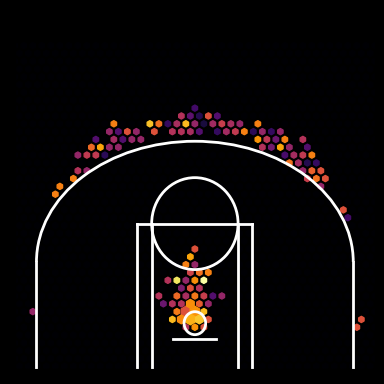

In [16]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

ax.scatter(x, y, c=z, cmap=cmap, marker='h', s=sizes)

# Draw court
ax = create_court(ax, 'white')

## Volume of Shots Chart

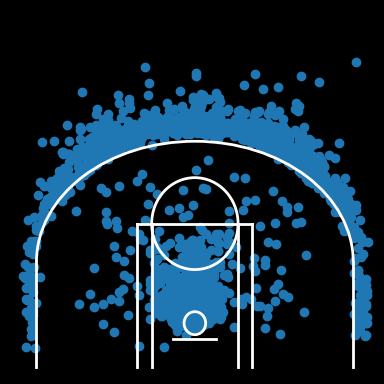

In [17]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

ax.scatter(shot_data.LOC_X, shot_data.LOC_Y + 60, cmap=cmap, marker='o')

# Draw court
ax = create_court(ax, 'white')

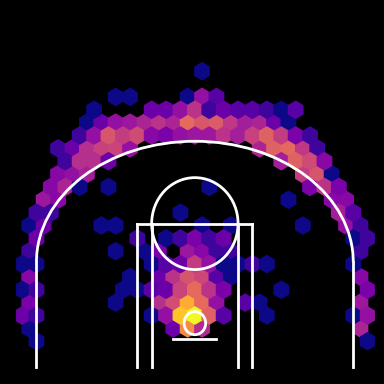

In [18]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

# Plot hexbin of shots
#ax.hexbin(shot_data['LOC_X'], shot_data['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), cmap='inferno')
hexbin = ax.hexbin(shot_data.LOC_X, shot_data.LOC_Y + 60, cmap='plasma',
          bins="log", gridsize=25, mincnt=2, extent=(-250, 250, 422.5, -47.5))


# Draw court
ax = create_court(ax, 'white')

# Annotate player name and season
#ax.text(0, 1.05, 'Isaiah Thomas\n2016-17 Season', transform=ax.transAxes, ha='left', va='baseline')

# Save and show figure
# plt.savefig('ShotChart.png', dpi=300, bbox_inches='tight')
plt.show()

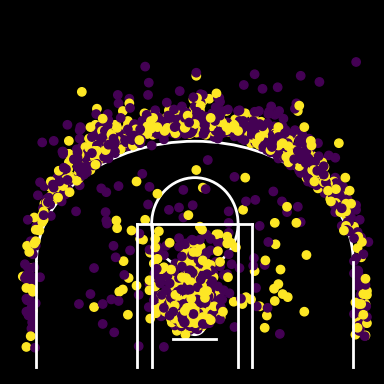

In [19]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

ax = create_court(ax, 'white')
ax.scatter(shot_data.LOC_X, shot_data.LOC_Y + 60, c=shot_data.SHOT_MADE_FLAG)
